In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# check content of drive
!ls "/content/drive/My Drive/Thesis Internal/Code"

 01_models_test_cases					  'old datasets used'
 audio_augmentation					   Pretagging
 Axl_Test						   resnet_testcases.gsheet
 binary_audio_cleaned_cropped				   Russel_Test
 binary_test_split_audio_Depression_AVEC2017_2		   test_binary_vandanaModel.ipynb
 binary_train_split_audio_Depression_AVEC2017_2		   test_customModel1.ipynb
'Copy of test_InceptionV3_model1 [ITO NA YUN AXL].ipynb'   test_inceptionV3_model1.ipynb
 dev_split_mfcc_augmented_Depression_AVEC2017_2		   test_InceptionV3_model1_V2.ipynb
 dev_split_mfcc_augmented_Depression_AVEC2017_2_VERSION2   test_predict
 Eli_Test						   test_split_audio_Depression_AVEC2017_2
 inceptionV3_model1_testcases.gsheet			   test_split_mfcc_Depression_AVEC2017_2
 model							   train_split_audio_Depression_AVEC2017_2
 model_tuning						   train_split_mfcc_Depression_AVEC2017_2


In [ ]:
%matplotlib inline
from IPython import display
import os
import math
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.metrics import *
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

np.random.seed(42)
tf.random.set_seed(42)

## Importing and Splitting the dataset

In [2]:
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

data_dir = "/content/drive/My Drive/Thesis Internal/Code/train_split_mfcc_Depression_AVEC2017_2" #change_path
test_data_dir = "/content/drive/My Drive/Thesis Internal/Code/test_split_mfcc_Depression_AVEC2017_2" #change_path

aug_data_dir = "/content/drive/My Drive/Thesis Internal/Code/dev_split_mfcc_augmented_Depression_AVEC2017_2" #change_path

def image_generator(height, width):
    datagen = ImageDataGenerator(
        rescale=1./255.,
        validation_split=0.1, #to change split
    )

    test_datagen = ImageDataGenerator(
        rescale=1./255.
    )

    aug_datagen = ImageDataGenerator(
        rescale=1./255.
    )

    # Modify the flow_from_directory method to handle 5 classes
    train_ds = datagen.flow_from_directory(
        data_dir,
        batch_size=batch_size,
        subset="training",
        shuffle=True,
        class_mode='categorical', #changed
        target_size=(height, width),
        classes={'level_0': 0, 'level_1': 1, 'level_2': 2, 'level_3': 3, 'level_4': 4}
    )

    val_ds = datagen.flow_from_directory(
        data_dir,
        subset="validation",
        class_mode='categorical', #changed
        target_size=(height, width),
        batch_size=batch_size,
        classes={'level_0': 0, 'level_1': 1, 'level_2': 2, 'level_3': 3, 'level_4': 4}
    )

    test_ds = test_datagen.flow_from_directory(
        test_data_dir,
        batch_size=batch_size,
        shuffle=True,
        class_mode='categorical', #changed
        target_size=(height, width),
        classes={'level_0': 0, 'level_1': 1, 'level_2': 2, 'level_3': 3, 'level_4': 4}
    )

    aug_train_ds = aug_datagen.flow_from_directory(
        aug_data_dir,
        batch_size=batch_size,
        shuffle=True,
        class_mode='categorical', #changed
        target_size=(height, width),
        classes={'level_0': 0, 'level_1': 1, 'level_2': 2, 'level_3': 3, 'level_4': 4}
    )

    return train_ds, val_ds, test_ds, aug_train_ds

batch_size = 32  # add batch_size here or elsewhere in your code
height, width = 400, 1000  #change
train_ds, val_ds, test_ds, aug_train_ds = image_generator(height, width)

# Change your print statement to reflect the 5 classes
total_image = np.concatenate([train_ds.labels, val_ds.labels])
class_counts = {}
for i in range(5):
    class_name = f'level_{i}'
    class_counts[class_name] = len(np.where(total_image==i)[0])

print('\n\n', class_counts)


Found 0 images belonging to 5 classes.
Found 0 images belonging to 5 classes.
Found 0 images belonging to 5 classes.
Found 0 images belonging to 5 classes.


 {'level_0': 0, 'level_1': 0, 'level_2': 0, 'level_3': 0, 'level_4': 0}


## Visualizing the dataset

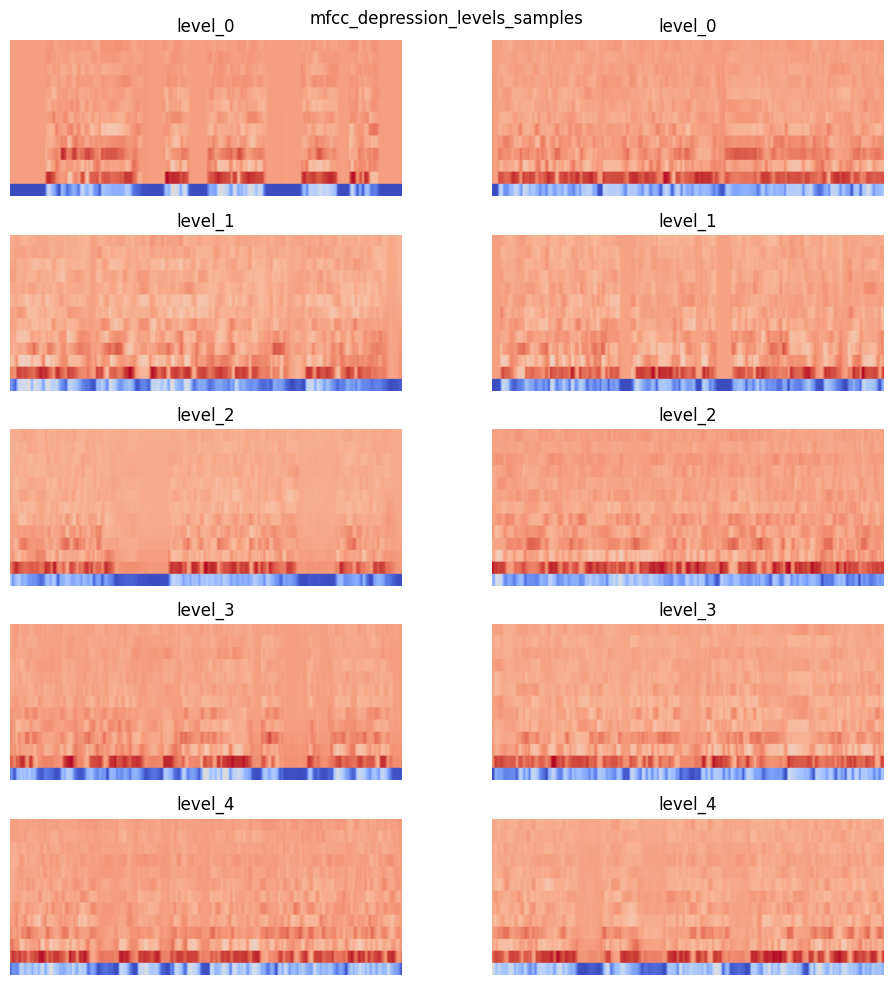

In [ ]:
import matplotlib.pyplot as plt

# single_image_height = 4  # inches
# single_image_width = single_image_height * 2.5  # inches

# fig_width = 2 * single_image_width  # since there are 2 columns
# fig_height = 5 * single_image_height  # since there are 5 rows

# fig, ax = plt.subplots(5, 2, figsize=(fig_width, fig_height))
fig, ax = plt.subplots(5, 2, figsize=(10, 10))  # 5 levels x 2 samples
fig.suptitle("mfcc_depression_levels_samples")

class_dict = {v: k for k, v in train_ds.class_indices.items()}
samples_needed = {k: 2 for k in range(5)}
collected_samples = {k: [] for k in range(5)}

while any(v > 0 for v in samples_needed.values()):
    images, labels = train_ds.next()
    for image, label in zip(images, labels):
        label_index = np.argmax(label)
        if samples_needed[label_index] > 0:
            collected_samples[label_index].append(image)
            samples_needed[label_index] -= 1

# Plot the collected samples
for label_index, images_list in collected_samples.items():
    for i, image in enumerate(images_list):
        ax[label_index, i].imshow(image)
        ax[label_index, i].set_title(f'{class_dict[label_index]}')
        ax[label_index, i].axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.95)  # Adjust the top space for the main title
plt.show()


## Visualizing the augmented dataset

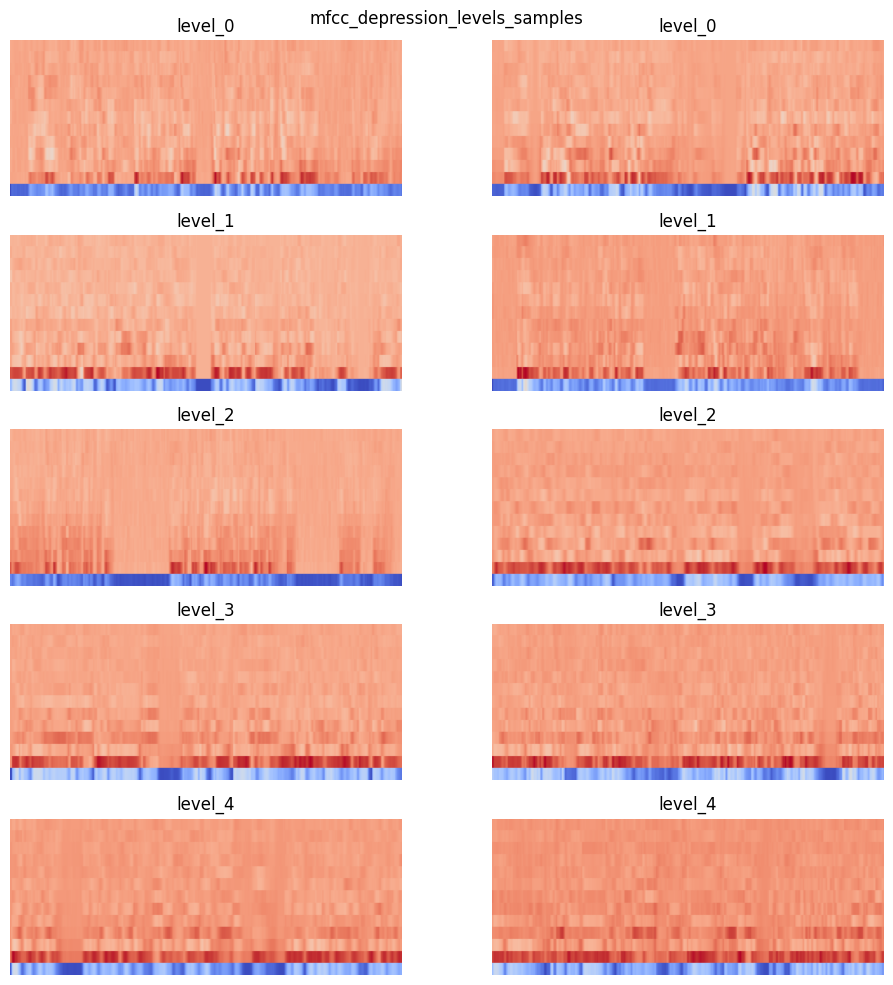

In [ ]:
import matplotlib.pyplot as plt

# single_image_height = 4  # inches
# single_image_width = single_image_height * 2.5  # inches

# fig_width = 2 * single_image_width  # since there are 2 columns
# fig_height = 5 * single_image_height  # since there are 5 rows

# fig, ax = plt.subplots(5, 2, figsize=(fig_width, fig_height))
fig, ax = plt.subplots(5, 2, figsize=(10, 10))  # 5 levels x 2 samples
fig.suptitle("mfcc_depression_levels_samples")

class_dict = {v: k for k, v in aug_train_ds.class_indices.items()}
samples_needed = {k: 2 for k in range(5)}
collected_samples = {k: [] for k in range(5)}

while any(v > 0 for v in samples_needed.values()):
    images, labels = aug_train_ds.next()
    for image, label in zip(images, labels):
        label_index = np.argmax(label)
        if samples_needed[label_index] > 0:
            collected_samples[label_index].append(image)
            samples_needed[label_index] -= 1

# Plot the collected samples
for label_index, images_list in collected_samples.items():
    for i, image in enumerate(images_list):
        ax[label_index, i].imshow(image)
        ax[label_index, i].set_title(f'{class_dict[label_index]}')
        ax[label_index, i].axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.95)  # Adjust the top space for the main title
plt.show()


# Applying Class Weights to address Imbalanced dataset

In [ ]:
#adding class weights
from sklearn.utils.class_weight import compute_class_weight

# Assuming train_ds.classes provides the class indices of the training data
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_ds.classes),
    y=train_ds.classes
)

# Turn class_weights into a dictionary to use it with Keras
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}


## To keep track of Time duration during training

In [ ]:
import time

class TimingCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super(TimingCallback, self).__init__()
        self.epoch_times = []

    def on_epoch_begin(self, epoch, logs=None):
        self.start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        elapsed_time = time.time() - self.start_time
        self.epoch_times.append(elapsed_time)
        print(f"Epoch {epoch + 1}: {elapsed_time:.2f} seconds")

    def on_train_begin(self, logs=None):
        self.total_time = time.time()

    def on_train_end(self, logs=None):
        total_time_elapsed = time.time() - self.total_time
        avg_time_per_epoch = sum(self.epoch_times) / len(self.epoch_times)
        print(f"Total training time: {total_time_elapsed:.2f} seconds")
        print(f"Average time per epoch: {avg_time_per_epoch:.2f} seconds")


## Initial VGG16 Model


In [3]:
import tensorflow as tf
from tensorflow.keras.regularizers import l2

# from keras.layers.experimental import preprocessing

tf.keras.backend.clear_session()

input_shape = (height, width, 3)

base_model_vgg16 = tf.keras.applications.vgg16.VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=input_shape
)
base_model_vgg16.trainable = False

model_vgg16 = tf.keras.Sequential()
model_vgg16.add(base_model_vgg16)
model_vgg16.add(tf.keras.layers.Flatten())
# model_vgg16.add(tf.keras.layers.BatchNormalization())
model_vgg16.add(tf.keras.layers.Dense(256, activation='relu'))

model_vgg16.add(tf.keras.layers.Dropout(0.2)) #change

# # Adjusted for 5 classes with softmax activation
model_vgg16.add(tf.keras.layers.Dense(5, activation='softmax'))

# Use categorical_crossentropy instead of binary_crossentropy
model_vgg16.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(0.0001),
              metrics=['accuracy'])
model_vgg16.summary()


58889256/58889256 [==============================] - 4s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 12, 31, 512)       14714688  
                                                                 
 flatten (Flatten)           (None, 190464)            0         
                                                                 
 dense (Dense)               (None, 256)               48759040  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 63475013 (242.14 MB)
Trainable params: 48760325 (186.01 MB)
Non-trainable params: 14714688 (56.13 MB)
_______

In [ ]:
# Adjusting to monitor validation accuracy
checkpoint = tf.keras.callbacks.ModelCheckpoint('/content/drive/My Drive/Thesis Internal/Code/model_tuning/vgg16_initialv5.h5', monitor='val_loss', verbose=1, mode='min', save_best_only=True)
early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", restore_best_weights=True, patience=5)
time_callback = TimingCallback()
callbacks_list = [checkpoint, early, time_callback]
# callbacks_list = [checkpoint]

history = model_vgg16.fit(
        train_ds,
        validation_data=val_ds,
        epochs=50,
        shuffle=True,
        verbose=True,
        callbacks=callbacks_list,
        class_weight=class_weight_dict  # Pass class weights here
)

Epoch 1/50
5/5 [==============================] - ETA: 0s - loss: 3.9880 - accuracy: 0.2385
Epoch 1: val_loss improved from inf to 4.21284, saving model to /content/drive/My Drive/Thesis Internal/Code/model_tuning/vgg16_initialv5.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1: 47.29 seconds
5/5 [==============================] - 47s 5s/step - loss: 3.9880 - accuracy: 0.2385 - val_loss: 4.2128 - val_accuracy: 0.1667
Epoch 2/50
5/5 [==============================] - ETA: 0s - loss: 2.9082 - accuracy: 0.1692
Epoch 2: val_loss improved from 4.21284 to 1.38665, saving model to /content/drive/My Drive/Thesis Internal/Code/model_tuning/vgg16_initialv5.h5
Epoch 2: 8.34 seconds
5/5 [==============================] - 8s 2s/step - loss: 2.9082 - accuracy: 0.1692 - val_loss: 1.3866 - val_accuracy: 0.5000
Epoch 3/50
5/5 [==============================] - ETA: 0s - loss: 2.5597 - accuracy: 0.4154
Epoch 3: val_loss did not improve from 1.38665
Epoch 3: 5.23 seconds
5/5 [==============================] - 5s 915ms/step - loss: 2.5597 - accuracy: 0.4154 - val_loss: 1.6359 - val_accuracy: 0.5000
Epoch 4/50
5/5 [==============================] - ETA: 0s - loss: 2.2386 - accuracy: 0.1769
Epoch 4: val_loss did not improve from 1.38665
Epoch 4: 5.22 seconds
5/5 [=========

## Evaluation of *Initial Model*

In [ ]:
train_result = model_vgg16.evaluate(train_ds)
val_result = model_vgg16.evaluate(val_ds)
test_result = model_vgg16.evaluate(test_ds)

no_augmented_df = pd.DataFrame(zip(train_result,val_result,test_result),columns=['Train','Val','Test'],index=['Loss','Acc'])
no_augmented_df

2/2 [==============================] - 15s 13s/step - loss: 1.3043 - accuracy: 0.4681


,Train,Val,Test
Loss,1.208947,1.252233,1.304332
Acc,0.446154,0.500000,0.468085


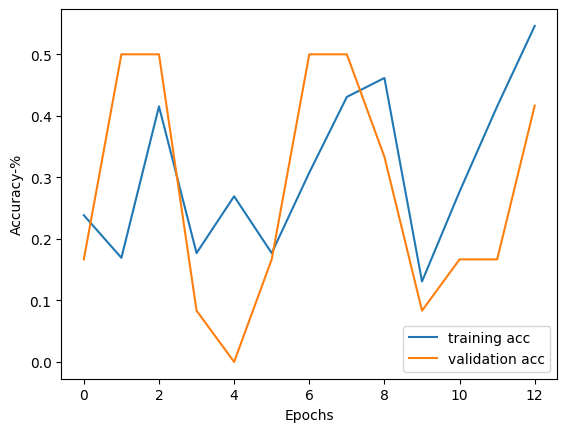

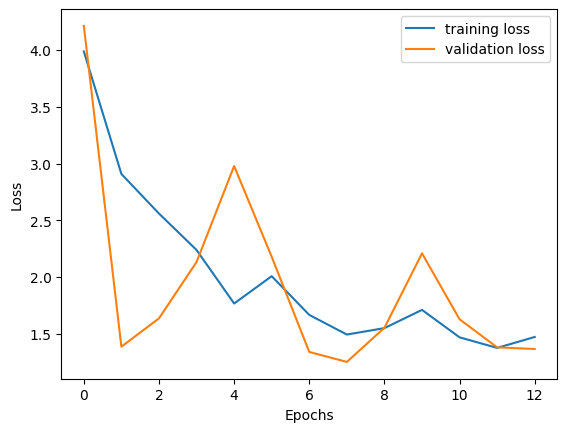

In [ ]:
# plot learning curve
def plot_learning_curve(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, label='training acc')
    plt.plot(epochs, val_acc, label='validation acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy-%')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

plot_learning_curve(history)

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# 1. Predict the classes and probabilities for the test dataset
test_pred_prob = model_vgg16.predict(test_ds)
test_pred = np.argmax(test_pred_prob, axis=1)
test_true = test_ds.labels

# Determine the number of classes in the test dataset
n_classes = len(np.unique(test_true))

# 2. Compute the metrics for the test dataset

# Test metrics
test_precision = precision_score(test_true, test_pred, average='weighted', zero_division=1)
test_recall = recall_score(test_true, test_pred, average='weighted')
test_f1 = f1_score(test_true, test_pred, average='weighted')
test_conf_matrix = confusion_matrix(test_true, test_pred, labels=list(range(n_classes)))
test_true_onehot = np.eye(n_classes)[test_true]
test_roc_auc = roc_auc_score(test_true_onehot, test_pred_prob, multi_class='ovr')

# Create a dataframe to display the results for the test set
test_metrics_df = pd.DataFrame({
    'Test': [test_precision, test_recall, test_f1, test_roc_auc]
}, index=['Precision', 'Recall', 'F1 Score', 'AUC'])

print("Test Metrics DataFrame:")
print(test_metrics_df)

print("\nTest Confusion Matrix:")
print(test_conf_matrix)


2/2 [==============================] - 2s 1s/step
Test Metrics DataFrame:
               Test
Precision  0.751019
Recall     0.468085
F1 Score   0.298489
AUC        0.544380

Test Confusion Matrix:
[[22  0  0  0  0]
 [11  0  0  0  0]
 [ 5  0  0  0  0]
 [ 7  0  0  0  0]
 [ 2  0  0  0  0]]


In [ ]:
# Assuming test_conf_matrix is already computed as shown in your code
n_classes = len(np.unique(test_true))  # Number of classes

# Initialize arrays to store TP, FP, FN, TN for each class
TP = np.zeros(n_classes)
FP = np.zeros(n_classes)
FN = np.zeros(n_classes)
TN = np.zeros(n_classes)

# Calculate TP, FP, FN, TN for each class
for i in range(n_classes):
    TP[i] = test_conf_matrix[i, i]
    FP[i] = test_conf_matrix[:, i].sum() - TP[i]
    FN[i] = test_conf_matrix[i, :].sum() - TP[i]
    TN[i] = test_conf_matrix.sum() - (FP[i] + FN[i] + TP[i])

print("Confusion Matrix Metrics by Class:")
TP_list = TP.tolist()
TN_list = TN.tolist()
FP_list = FP.tolist()
FN_list = FN.tolist()

metrics_by_class = list(zip(TP_list, TN_list, FP_list, FN_list))

# Print the transposed lists
for i, class_metrics in enumerate(metrics_by_class):
    print(f"Class {i}: {class_metrics}")

Confusion Matrix Metrics by Class:
Class 0: (22.0, 0.0, 25.0, 0.0)
Class 1: (0.0, 36.0, 0.0, 11.0)
Class 2: (0.0, 42.0, 0.0, 5.0)
Class 3: (0.0, 40.0, 0.0, 7.0)
Class 4: (0.0, 45.0, 0.0, 2.0)


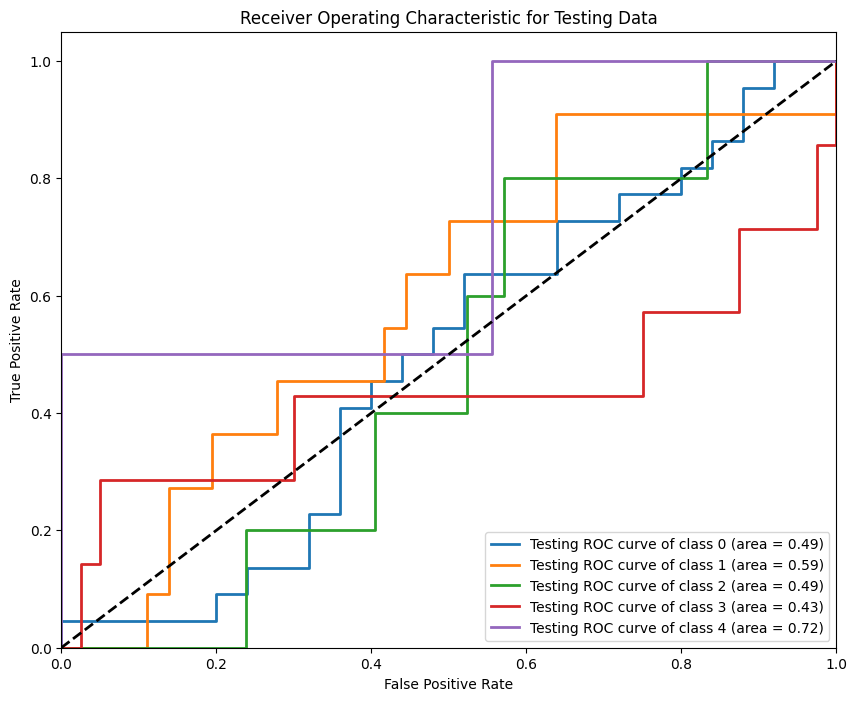

In [ ]:
#Matrix Visualization
# Training AUC curve
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(test_true_onehot[:, i], test_pred_prob[:, i])
    plt.plot(fpr, tpr, lw=2, label=f'Testing ROC curve of class {i} (area = {auc(fpr, tpr):.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Testing Data')
plt.legend(loc="lower right")
plt.show()

**TEST CASES INSERTION**

In [ ]:
import gspread
from google.colab import auth
from google.auth import default
from gspread.utils import rowcol_to_a1

# Authenticate the user
auth.authenticate_user()

# Create a gspread client using the authenticated Google credentials
creds, _ = default()
gc = gspread.authorize(creds)

# Open a spreadsheet by its title or URL
spreadsheet = gc.open('vgg16_testcases')  # Replace with your spreadsheet name
sheet = spreadsheet.sheet1  # Access the first sheet

# Assuming that the TP_list, TN_list, FP_list, and FN_list have been calculated
TP_list = TP.tolist()
TN_list = TN.tolist()
FP_list = FP.tolist()
FN_list = FN.tolist()
metrics_flat = [item for sublist in zip(TP_list, TN_list, FP_list, FN_list) for item in sublist]

# Data to append
data_to_append = [
    #ACCCURACY AND LOSS
    train_result[0],  # Training loss [B]
    train_result[1],  # Training accuracy [C]
    val_result[0],    # Validation loss [D]
    val_result[1],     # Validation accuracy [E]
    test_result[0],    # Testing loss [F]
    test_result[1],     # Testing accuracy [G]
    test_precision,
    test_recall,
    test_f1,
    test_roc_auc
]

#Insertion
# Find the first empty row in column B
col_values = sheet.col_values(2)  # Column number for 'B' is 2
first_empty_row = len(col_values) + 1

# Calculate the range to update
start_cell = rowcol_to_a1(first_empty_row, 2)  # Start at column B
end_cell = rowcol_to_a1(first_empty_row, 1 + len(data_to_append))  # Adjust the end column based on data length
cell_range = f"{start_cell}:{end_cell}"

# Update the entire row at once
sheet.update(cell_range, [data_to_append])

#FOR CONFUSION MATRIX INSERTION
# Loop through the metrics_flat and update each cell
for index, value in enumerate(metrics_flat):
    # Calculate row and column offset
    row_offset = (index // 4) + first_empty_row
    col_offset = (index % 4) + 12

    # Convert to A1 notation and update the cell
    cell_range = rowcol_to_a1(first_empty_row, 12) + ':' + rowcol_to_a1(first_empty_row, 12 + len(metrics_flat) - 1)
    sheet.update(cell_range, [metrics_flat])

In [ ]:
# Add a ReduceLROnPlateau callback to reduce the learning rate when the validation loss plateaus
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.000001, #to change reduce_lr
    verbose=1
)
callbacks_list = [checkpoint, early, time_callback, reduce_lr]

history = model_vgg16.fit(
        aug_train_ds,
        validation_data=val_ds,
        epochs=70,
        shuffle=True,
        verbose=True,
        callbacks=callbacks_list,
        class_weight=class_weight_dict  # Pass class weights here
        )


Epoch 1/70
18/18 [==============================] - ETA: 0s - loss: 1.6972 - accuracy: 0.2981
Epoch 1: val_loss did not improve from 1.25223
Epoch 1: 100.15 seconds
18/18 [==============================] - 100s 5s/step - loss: 1.6972 - accuracy: 0.2981 - val_loss: 1.3990 - val_accuracy: 0.5833 - lr: 1.0000e-04
Epoch 2/70
18/18 [==============================] - ETA: 0s - loss: 1.6364 - accuracy: 0.2363
Epoch 2: val_loss did not improve from 1.25223
Epoch 2: 20.63 seconds
18/18 [==============================] - 21s 1s/step - loss: 1.6364 - accuracy: 0.2363 - val_loss: 1.5869 - val_accuracy: 0.1667 - lr: 1.0000e-04
Epoch 3/70
18/18 [==============================] - ETA: 0s - loss: 1.5671 - accuracy: 0.2998
Epoch 3: val_loss did not improve from 1.25223
Epoch 3: 20.88 seconds
18/18 [==============================] - 21s 1s/step - loss: 1.5671 - accuracy: 0.2998 - val_loss: 1.3771 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 4/70
18/18 [==============================] - ETA: 0s - loss: 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 15: 23.85 seconds
18/18 [==============================] - 24s 1s/step - loss: 1.4048 - accuracy: 0.4533 - val_loss: 1.2026 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 16/70
18/18 [==============================] - ETA: 0s - loss: 1.3702 - accuracy: 0.5097
Epoch 16: val_loss did not improve from 1.20263
Epoch 16: 20.22 seconds
18/18 [==============================] - 20s 1s/step - loss: 1.3702 - accuracy: 0.5097 - val_loss: 1.2042 - val_accuracy: 0.5833 - lr: 1.0000e-04
Epoch 17/70
18/18 [==============================] - ETA: 0s - loss: 1.3479 - accuracy: 0.5026
Epoch 17: val_loss improved from 1.20263 to 1.19380, saving model to /content/drive/My Drive/Thesis Internal/Code/model_tuning/vgg16_initialv5.h5
Epoch 17: 23.90 seconds
18/18 [==============================] - 24s 1s/step - loss: 1.3479 - accuracy: 0.5026 - val_loss: 1.1938 - val_accuracy: 0.5833 - lr: 1.0000e-04
Epoch 18/70
18/18 [==============================] - ETA: 0s - loss: 1.3393 - accuracy: 0.5238
Epoch 18: v

## Evaluation of *Initial Model* with **Augmentation**

In [ ]:
train_result = model_vgg16.evaluate(train_ds)
val_result = model_vgg16.evaluate(val_ds)
test_result = model_vgg16.evaluate(test_ds)

augmented_df = pd.DataFrame(zip(train_result,val_result,test_result),columns=['Train','Val','Test'],index=['Loss','Acc'])
augmented_df

2/2 [==============================] - 2s 482ms/step - loss: 0.6024 - accuracy: 0.8298


,Train,Val,Test
Loss,0.628729,0.720001,0.602403
Acc,0.823077,0.833333,0.829787


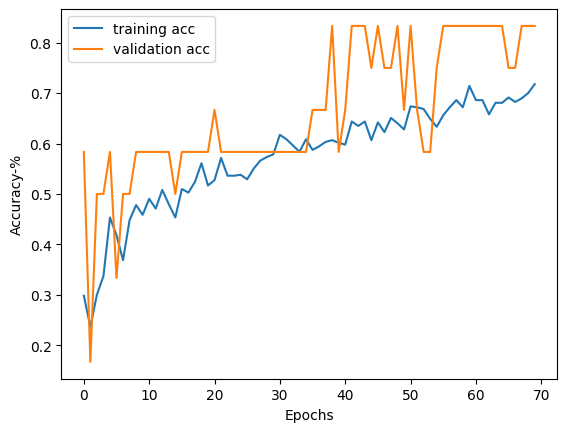

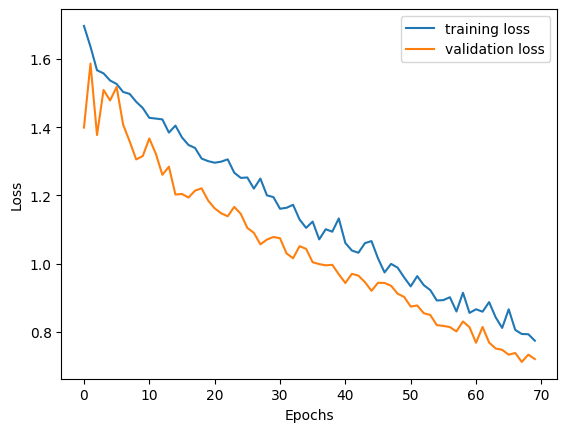

In [ ]:
# plot learning curve
def plot_learning_curve(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, label='training acc')
    plt.plot(epochs, val_acc, label='validation acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy-%')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

plot_learning_curve(history)

In [ ]:
#METRICS
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# 1. Predict the classes and probabilities for the test dataset
test_pred_prob = model_vgg16.predict(test_ds)
test_pred = np.argmax(test_pred_prob, axis=1)
test_true = test_ds.labels

# Determine the number of classes in the test dataset
n_classes = len(np.unique(test_true))

# 2. Compute the metrics for the test dataset

# Test metrics
test_precision = precision_score(test_true, test_pred, average='weighted', zero_division=1)
test_recall = recall_score(test_true, test_pred, average='weighted')
test_f1 = f1_score(test_true, test_pred, average='weighted')
test_conf_matrix = confusion_matrix(test_true, test_pred, labels=list(range(n_classes)))
test_true_onehot = np.eye(n_classes)[test_true]
test_roc_auc = roc_auc_score(test_true_onehot, test_pred_prob, multi_class='ovr')

# Create a dataframe to display the results for the test set
test_metrics_df = pd.DataFrame({
    'Test': [test_precision, test_recall, test_f1, test_roc_auc]
}, index=['Precision', 'Recall', 'F1 Score', 'AUC'])

print("Test Metrics DataFrame:")
print(test_metrics_df)

print("\nTest Confusion Matrix:")
print(test_conf_matrix)


2/2 [==============================] - 2s 1s/step
Test Metrics DataFrame:
               Test
Precision  0.341510
Recall     0.361702
F1 Score   0.349612
AUC        0.437316

Test Confusion Matrix:
[[12  4  1  4  1]
 [ 4  3  0  4  0]
 [ 3  0  0  1  1]
 [ 3  2  0  2  0]
 [ 1  1  0  0  0]]


In [ ]:
# Assuming test_conf_matrix is already computed as shown in your code
n_classes = len(np.unique(test_true))  # Number of classes

# Initialize arrays to store TP, FP, FN, TN for each class
TP = np.zeros(n_classes)
FP = np.zeros(n_classes)
FN = np.zeros(n_classes)
TN = np.zeros(n_classes)

# Calculate TP, FP, FN, TN for each class
for i in range(n_classes):
    TP[i] = test_conf_matrix[i, i]
    FP[i] = test_conf_matrix[:, i].sum() - TP[i]
    FN[i] = test_conf_matrix[i, :].sum() - TP[i]
    TN[i] = test_conf_matrix.sum() - (FP[i] + FN[i] + TP[i])

print("Confusion Matrix Metrics by Class:")
TP_list = TP.tolist()
TN_list = TN.tolist()
FP_list = FP.tolist()
FN_list = FN.tolist()

metrics_by_class = list(zip(TP_list, TN_list, FP_list, FN_list))

# Print the transposed lists
for i, class_metrics in enumerate(metrics_by_class):
    print(f"Class {i}: {class_metrics}")

Confusion Matrix Metrics by Class:
Class 0: (12.0, 14.0, 11.0, 10.0)
Class 1: (3.0, 29.0, 7.0, 8.0)
Class 2: (0.0, 41.0, 1.0, 5.0)
Class 3: (2.0, 31.0, 9.0, 5.0)
Class 4: (0.0, 43.0, 2.0, 2.0)


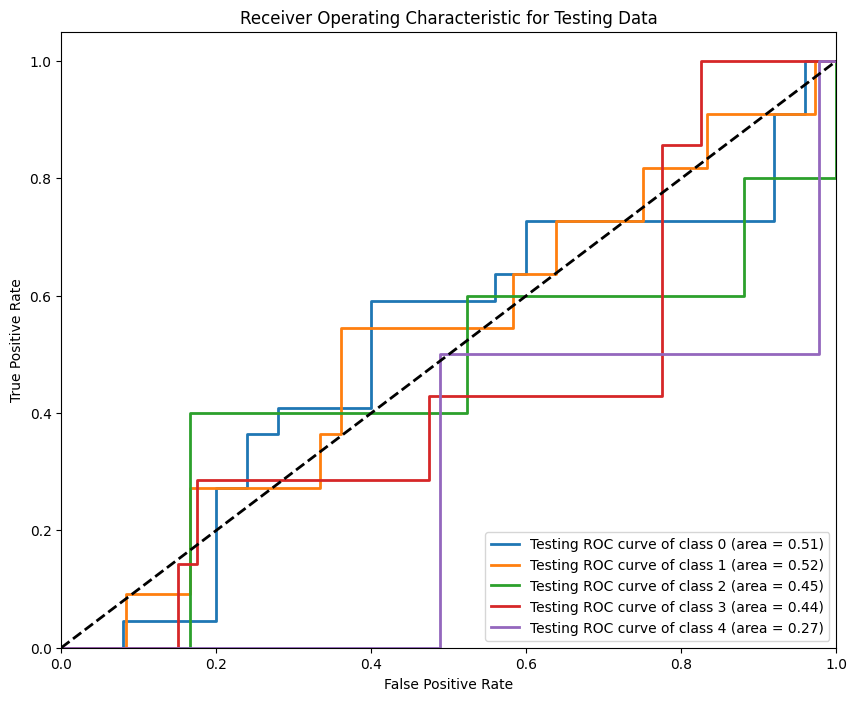

In [ ]:
#Matrix Visualization
# Testing AUC curve
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(test_true_onehot[:, i], test_pred_prob[:, i])
    plt.plot(fpr, tpr, lw=2, label=f'Testing ROC curve of class {i} (area = {auc(fpr, tpr):.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Testing Data')
plt.legend(loc="lower right")
plt.show()

In [ ]:
#TEST CASES INSERTION

# Assuming that the TP_list, TN_list, FP_list, and FN_list have been calculated
TP_list = TP.tolist()
TN_list = TN.tolist()
FP_list = FP.tolist()
FN_list = FN.tolist()
metrics_flat = [item for sublist in zip(TP_list, TN_list, FP_list, FN_list) for item in sublist]

# Data to append
data_to_append = [
    #ACCCURACY AND LOSS
    train_result[0],  # Training loss [B]
    train_result[1],  # Training accuracy [C]
    val_result[0],    # Validation loss [D]
    val_result[1],     # Validation accuracy [E]
    test_result[0],    # Testing loss [F]
    test_result[1],     # Testing accuracy [G]
    test_precision,
    test_recall,
    test_f1,
    test_roc_auc
]

#Insertion
# Find the first empty row in column B
col_values = sheet.col_values(2)  # Column number for 'B' is 2
first_empty_row = len(col_values) + 1

# Calculate the range to update
start_cell = rowcol_to_a1(first_empty_row, 2)  # Start at column B
end_cell = rowcol_to_a1(first_empty_row, 1 + len(data_to_append))  # Adjust the end column based on data length
cell_range = f"{start_cell}:{end_cell}"

# Update the entire row at once
sheet.update(cell_range, [data_to_append])

#FOR CONFUSION MATRIX INSERTION
# Loop through the metrics_flat and update each cell
for index, value in enumerate(metrics_flat):
    # Calculate row and column offset
    row_offset = (index // 4) + first_empty_row
    col_offset = (index % 4) + 12

    # Convert to A1 notation and update the cell
    cell_range = rowcol_to_a1(first_empty_row, 12) + ':' + rowcol_to_a1(first_empty_row, 12 + len(metrics_flat) - 1)
    sheet.update(cell_range, [metrics_flat])

## Improved VGG16 Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.regularizers import l2

tf.keras.backend.clear_session()

input_shape = (height, width, 3)

# Load the VGG16 model, pretrained on ImageNet
base_model_vgg16 = tf.keras.applications.vgg16.VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=input_shape
)

# Fine-tuning: Unfreeze the top layers of the model
base_model_vgg16.trainable = True
fine_tune_at = 15  # You can adjust this number

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model_vgg16.layers[:fine_tune_at]:
    layer.trainable = False

# Define the model
model_vgg16 = tf.keras.Sequential()
model_vgg16.add(base_model_vgg16)
model_vgg16.add(tf.keras.layers.Flatten())

# Add Batch Normalization
model_vgg16.add(tf.keras.layers.BatchNormalization())
model_vgg16.add(tf.keras.layers.Dense(256, activation='relu'))
model_vgg16.add(tf.keras.layers.BatchNormalization())

model_vgg16.add(tf.keras.layers.Dropout(0.2))  # Dropout

# Adjusted for 5 classes with softmax activation
model_vgg16.add(tf.keras.layers.Dense(5, activation='softmax'))

# Compile the model
model_vgg16.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(0.0001),
              metrics=['accuracy'])

# Model summary
model_vgg16.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 12, 31, 512)       14714688  
                                                                 
 flatten (Flatten)           (None, 190464)            0         
                                                                 
 batch_normalization (Batch  (None, 190464)            761856    
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               48759040  
                                                                 
 batch_normalization_1 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dropout (Dropout)           (None, 256)               0

In [ ]:
# Adjusting to monitor validation accuracy
checkpoint = tf.keras.callbacks.ModelCheckpoint('/content/drive/My Drive/Thesis Internal/Code/model_tuning/vgg16_tunedv5.h5', monitor='val_loss', verbose=1, mode='min', save_best_only=True)
early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", restore_best_weights=True, patience=5)
time_callback = TimingCallback()
callbacks_list = [checkpoint, early, time_callback]

history = model_vgg16.fit(
        train_ds,
        validation_data=val_ds,
        epochs=50,
        shuffle=True,
        verbose=True,
        callbacks=callbacks_list,
        class_weight=class_weight_dict  # Pass class weights here
)


Epoch 1/50
5/5 [==============================] - ETA: 0s - loss: 2.6005 - accuracy: 0.3615
Epoch 1: val_loss improved from inf to 1.38825, saving model to /content/drive/My Drive/Thesis Internal/Code/model_tuning/vgg16_tunedv5.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1: 14.27 seconds
5/5 [==============================] - 14s 2s/step - loss: 2.6005 - accuracy: 0.3615 - val_loss: 1.3882 - val_accuracy: 0.3333
Epoch 2/50
5/5 [==============================] - ETA: 0s - loss: 0.3910 - accuracy: 0.8077
Epoch 2: val_loss improved from 1.38825 to 1.14244, saving model to /content/drive/My Drive/Thesis Internal/Code/model_tuning/vgg16_tunedv5.h5
Epoch 2: 8.30 seconds
5/5 [==============================] - 8s 2s/step - loss: 0.3910 - accuracy: 0.8077 - val_loss: 1.1424 - val_accuracy: 0.5833
Epoch 3/50
5/5 [==============================] - ETA: 0s - loss: 0.1278 - accuracy: 0.9308
Epoch 3: val_loss did not improve from 1.14244
Epoch 3: 5.90 seconds
5/5 [==============================] - 6s 1s/step - loss: 0.1278 - accuracy: 0.9308 - val_loss: 1.4227 - val_accuracy: 0.5000
Epoch 4/50
5/5 [==============================] - ETA: 0s - loss: 0.1109 - accuracy: 0.9615
Epoch 4: val_loss did not improve from 1.14244
Epoch 4: 6.09 seconds
5/5 [==============

## Evaluation of *Tuned Model*

In [ ]:
train_result = model_vgg16.evaluate(train_ds)
val_result = model_vgg16.evaluate(val_ds)
test_result = model_vgg16.evaluate(test_ds)

no_augmented_df = pd.DataFrame(zip(train_result,val_result,test_result),columns=['Train','Val','Test'],index=['Loss','Acc'])
no_augmented_df

2/2 [==============================] - 2s 490ms/step - loss: 1.2796 - accuracy: 0.4043


,Train,Val,Test
Loss,0.824476,1.142436,1.279615
Acc,0.607692,0.583333,0.404255


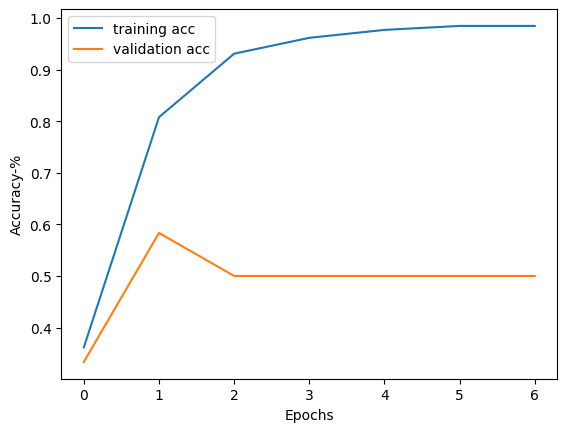

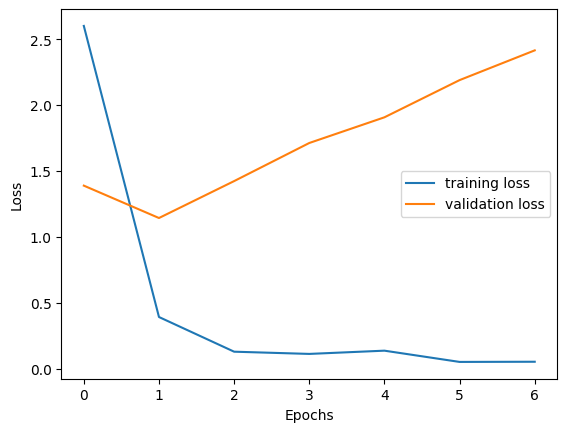

In [ ]:
# plot learning curve
def plot_learning_curve(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, label='training acc')
    plt.plot(epochs, val_acc, label='validation acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy-%')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

plot_learning_curve(history)

In [ ]:
#METRICS
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# 1. Predict the classes and probabilities for the test dataset
test_pred_prob = model_vgg16.predict(test_ds)
test_pred = np.argmax(test_pred_prob, axis=1)
test_true = test_ds.labels

# Determine the number of classes in the test dataset
n_classes = len(np.unique(test_true))

# 2. Compute the metrics for the test dataset

# Test metrics
test_precision = precision_score(test_true, test_pred, average='weighted', zero_division=1)
test_recall = recall_score(test_true, test_pred, average='weighted')
test_f1 = f1_score(test_true, test_pred, average='weighted')
test_conf_matrix = confusion_matrix(test_true, test_pred, labels=list(range(n_classes)))
test_true_onehot = np.eye(n_classes)[test_true]
test_roc_auc = roc_auc_score(test_true_onehot, test_pred_prob, multi_class='ovr')

# Create a dataframe to display the results for the test set
test_metrics_df = pd.DataFrame({
    'Test': [test_precision, test_recall, test_f1, test_roc_auc]
}, index=['Precision', 'Recall', 'F1 Score', 'AUC'])

print("Test Metrics DataFrame:")
print(test_metrics_df)

print("\nTest Confusion Matrix:")
print(test_conf_matrix)


2/2 [==============================] - 2s 1s/step
Test Metrics DataFrame:
               Test
Precision  0.625532
Recall     0.489362
F1 Score   0.365691
AUC        0.574320

Test Confusion Matrix:
[[21  1  0  0  0]
 [ 9  2  0  0  0]
 [ 5  0  0  0  0]
 [ 5  2  0  0  0]
 [ 2  0  0  0  0]]


In [ ]:
# Assuming test_conf_matrix is already computed as shown in your code
n_classes = len(np.unique(test_true))  # Number of classes

# Initialize arrays to store TP, FP, FN, TN for each class
TP = np.zeros(n_classes)
FP = np.zeros(n_classes)
FN = np.zeros(n_classes)
TN = np.zeros(n_classes)

# Calculate TP, FP, FN, TN for each class
for i in range(n_classes):
    TP[i] = test_conf_matrix[i, i]
    FP[i] = test_conf_matrix[:, i].sum() - TP[i]
    FN[i] = test_conf_matrix[i, :].sum() - TP[i]
    TN[i] = test_conf_matrix.sum() - (FP[i] + FN[i] + TP[i])

print("Confusion Matrix Metrics by Class:")
TP_list = TP.tolist()
TN_list = TN.tolist()
FP_list = FP.tolist()
FN_list = FN.tolist()

metrics_by_class = list(zip(TP_list, TN_list, FP_list, FN_list))

# Print the transposed lists
for i, class_metrics in enumerate(metrics_by_class):
    print(f"Class {i}: {class_metrics}")

Confusion Matrix Metrics by Class:
Class 0: (21.0, 4.0, 21.0, 1.0)
Class 1: (2.0, 33.0, 3.0, 9.0)
Class 2: (0.0, 42.0, 0.0, 5.0)
Class 3: (0.0, 40.0, 0.0, 7.0)
Class 4: (0.0, 45.0, 0.0, 2.0)


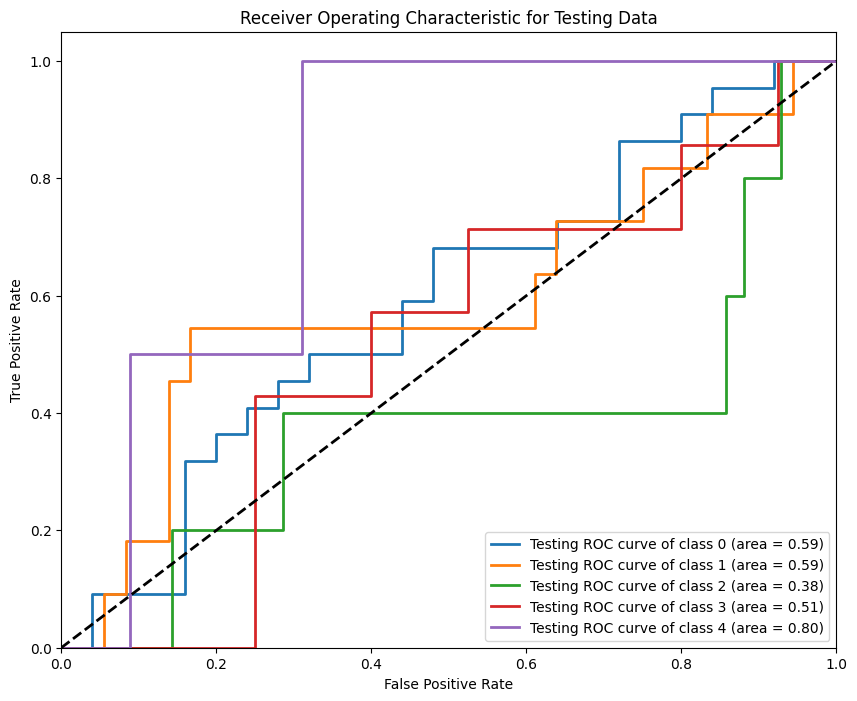

In [ ]:
#Matrix Visualization
# Training AUC curve
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(test_true_onehot[:, i], test_pred_prob[:, i])
    plt.plot(fpr, tpr, lw=2, label=f'Testing ROC curve of class {i} (area = {auc(fpr, tpr):.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Testing Data')
plt.legend(loc="lower right")
plt.show()

In [ ]:
#TEST CASES INSERTION

# Assuming that the TP_list, TN_list, FP_list, and FN_list have been calculated
TP_list = TP.tolist()
TN_list = TN.tolist()
FP_list = FP.tolist()
FN_list = FN.tolist()
metrics_flat = [item for sublist in zip(TP_list, TN_list, FP_list, FN_list) for item in sublist]

# Data to append
data_to_append = [
    #ACCCURACY AND LOSS
    train_result[0],  # Training loss [B]
    train_result[1],  # Training accuracy [C]
    val_result[0],    # Validation loss [D]
    val_result[1],     # Validation accuracy [E]
    test_result[0],    # Testing loss [F]
    test_result[1],     # Testing accuracy [G]
    test_precision,
    test_recall,
    test_f1,
    test_roc_auc
]

#Insertion
# Find the first empty row in column B
col_values = sheet.col_values(2)  # Column number for 'B' is 2
first_empty_row = len(col_values) + 1

# Calculate the range to update
start_cell = rowcol_to_a1(first_empty_row, 2)  # Start at column B
end_cell = rowcol_to_a1(first_empty_row, 1 + len(data_to_append))  # Adjust the end column based on data length
cell_range = f"{start_cell}:{end_cell}"

# Update the entire row at once
sheet.update(cell_range, [data_to_append])

#FOR CONFUSION MATRIX INSERTION
# Loop through the metrics_flat and update each cell
for index, value in enumerate(metrics_flat):
    # Calculate row and column offset
    row_offset = (index // 4) + first_empty_row
    col_offset = (index % 4) + 12

    # Convert to A1 notation and update the cell
    cell_range = rowcol_to_a1(first_empty_row, 12) + ':' + rowcol_to_a1(first_empty_row, 12 + len(metrics_flat) - 1)
    sheet.update(cell_range, [metrics_flat])

In [ ]:
# Add a ReduceLROnPlateau callback to reduce the learning rate when the validation loss plateaus
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.000001, #to change reduce_lr
    verbose=1
)
callbacks_list = [checkpoint, early, time_callback, reduce_lr]

history = model_vgg16.fit(
        aug_train_ds,
        validation_data=val_ds,
        epochs=70,
        shuffle=True,
        verbose=True,
        callbacks=callbacks_list,
        class_weight=class_weight_dict  # Pass class weights here
        )


Epoch 1/70
18/18 [==============================] - ETA: 0s - loss: 1.3334 - accuracy: 0.5944
Epoch 1: val_loss improved from 1.14244 to 0.90845, saving model to /content/drive/My Drive/Thesis Internal/Code/model_tuning/vgg16_tunedv5.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1: 29.06 seconds
18/18 [==============================] - 29s 2s/step - loss: 1.3334 - accuracy: 0.5944 - val_loss: 0.9084 - val_accuracy: 0.5833 - lr: 1.0000e-04
Epoch 2/70
18/18 [==============================] - ETA: 0s - loss: 0.2847 - accuracy: 0.8571
Epoch 2: val_loss did not improve from 0.90845
Epoch 2: 22.45 seconds
18/18 [==============================] - 22s 1s/step - loss: 0.2847 - accuracy: 0.8571 - val_loss: 1.0227 - val_accuracy: 0.6667 - lr: 1.0000e-04
Epoch 3/70
18/18 [==============================] - ETA: 0s - loss: 0.0854 - accuracy: 0.9718
Epoch 3: val_loss improved from 0.90845 to 0.86063, saving model to /content/drive/My Drive/Thesis Internal/Code/model_tuning/vgg16_tunedv5.h5
Epoch 3: 28.31 seconds
18/18 [==============================] - 28s 2s/step - loss: 0.0854 - accuracy: 0.9718 - val_loss: 0.8606 - val_accuracy: 0.7500 - lr: 1.0000e-04
Epoch 4/70
18/18 [==============================] - ETA: 0s - loss: 0.0368 - accuracy: 0.9841
Epoch 4: val_loss imp

## Evaluation of *Tuned Model* with **Augmentation**

In [ ]:
train_result = model_vgg16.evaluate(train_ds)
val_result = model_vgg16.evaluate(val_ds)
test_result = model_vgg16.evaluate(test_ds)

augmented_df = pd.DataFrame(zip(train_result,val_result,test_result),columns=['Train','Val','Test'],index=['Loss','Acc'])
augmented_df

2/2 [==============================] - 2s 489ms/step - loss: 0.0310 - accuracy: 1.0000


,Train,Val,Test
Loss,0.017907,0.045503,0.03097
Acc,1.000000,1.000000,1.00000


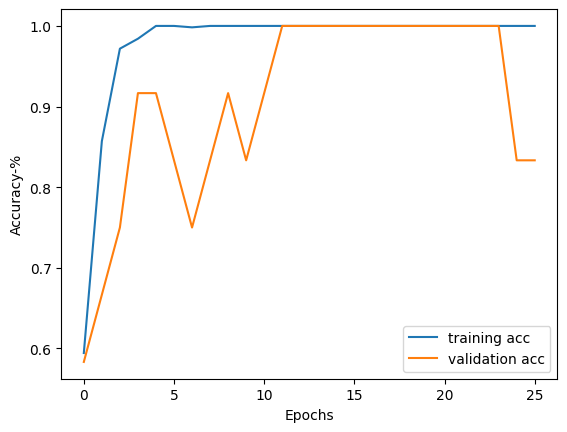

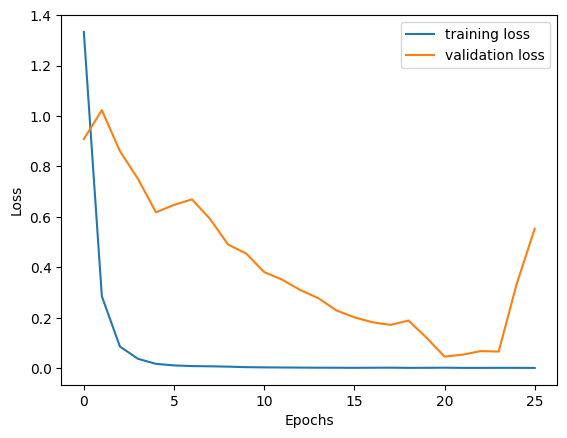

In [ ]:
# plot learning curve
def plot_learning_curve(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, label='training acc')
    plt.plot(epochs, val_acc, label='validation acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy-%')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

plot_learning_curve(history)

In [ ]:
#METRICS
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# 1. Predict the classes and probabilities for the test dataset
test_pred_prob = model_vgg16.predict(test_ds)
test_pred = np.argmax(test_pred_prob, axis=1)
test_true = test_ds.labels

# Determine the number of classes in the test dataset
n_classes = len(np.unique(test_true))

# 2. Compute the metrics for the test dataset

# Test metrics
test_precision = precision_score(test_true, test_pred, average='weighted', zero_division=1)
test_recall = recall_score(test_true, test_pred, average='weighted')
test_f1 = f1_score(test_true, test_pred, average='weighted')
test_conf_matrix = confusion_matrix(test_true, test_pred, labels=list(range(n_classes)))
test_true_onehot = np.eye(n_classes)[test_true]
test_roc_auc = roc_auc_score(test_true_onehot, test_pred_prob, multi_class='ovr')

# Create a dataframe to display the results for the test set
test_metrics_df = pd.DataFrame({
    'Test': [test_precision, test_recall, test_f1, test_roc_auc]
}, index=['Precision', 'Recall', 'F1 Score', 'AUC'])

print("Test Metrics DataFrame:")
print(test_metrics_df)

print("\nTest Confusion Matrix:")
print(test_conf_matrix)


2/2 [==============================] - 2s 1s/step
Test Metrics DataFrame:
               Test
Precision  0.382979
Recall     0.382979
F1 Score   0.382979
AUC        0.550297

Test Confusion Matrix:
[[13  4  0  4  1]
 [ 4  3  2  2  0]
 [ 1  1  2  1  0]
 [ 3  2  1  0  1]
 [ 1  1  0  0  0]]


In [ ]:
# Assuming test_conf_matrix is already computed as shown in your code
n_classes = len(np.unique(test_true))  # Number of classes

# Initialize arrays to store TP, FP, FN, TN for each class
TP = np.zeros(n_classes)
FP = np.zeros(n_classes)
FN = np.zeros(n_classes)
TN = np.zeros(n_classes)

# Calculate TP, FP, FN, TN for each class
for i in range(n_classes):
    TP[i] = test_conf_matrix[i, i]
    FP[i] = test_conf_matrix[:, i].sum() - TP[i]
    FN[i] = test_conf_matrix[i, :].sum() - TP[i]
    TN[i] = test_conf_matrix.sum() - (FP[i] + FN[i] + TP[i])

print("Confusion Matrix Metrics by Class:")
TP_list = TP.tolist()
TN_list = TN.tolist()
FP_list = FP.tolist()
FN_list = FN.tolist()

metrics_by_class = list(zip(TP_list, TN_list, FP_list, FN_list))

# Print the transposed lists
for i, class_metrics in enumerate(metrics_by_class):
    print(f"Class {i}: {class_metrics}")

Confusion Matrix Metrics by Class:
Class 0: (13.0, 16.0, 9.0, 9.0)
Class 1: (3.0, 28.0, 8.0, 8.0)
Class 2: (2.0, 39.0, 3.0, 3.0)
Class 3: (0.0, 33.0, 7.0, 7.0)
Class 4: (0.0, 43.0, 2.0, 2.0)


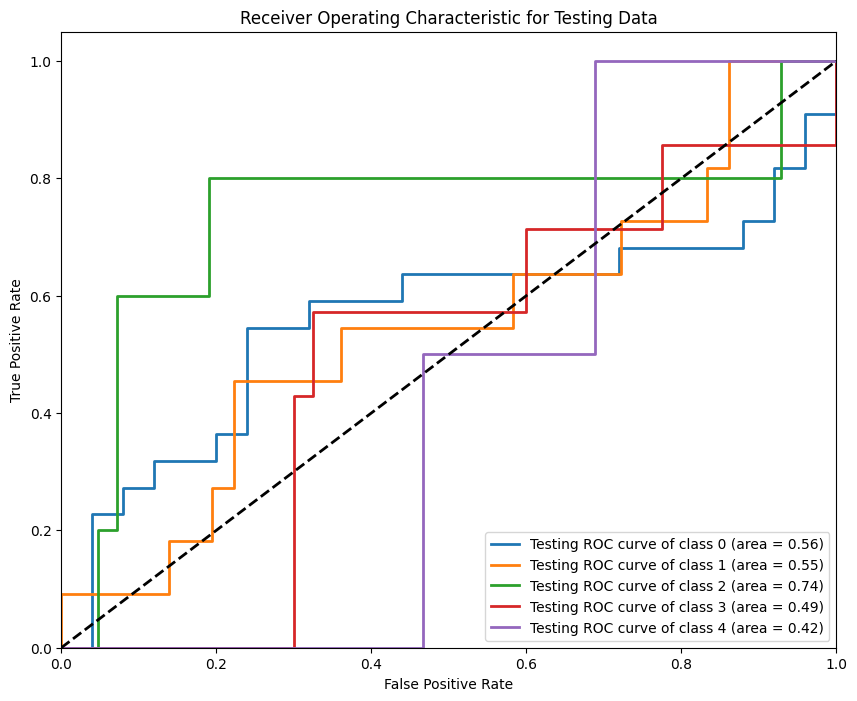

In [ ]:
#Matrix Visualization
# Training AUC curve
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(test_true_onehot[:, i], test_pred_prob[:, i])
    plt.plot(fpr, tpr, lw=2, label=f'Testing ROC curve of class {i} (area = {auc(fpr, tpr):.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Testing Data')
plt.legend(loc="lower right")
plt.show()

In [ ]:
#TEST CASES INSERTION

# Assuming that the TP_list, TN_list, FP_list, and FN_list have been calculated
TP_list = TP.tolist()
TN_list = TN.tolist()
FP_list = FP.tolist()
FN_list = FN.tolist()
metrics_flat = [item for sublist in zip(TP_list, TN_list, FP_list, FN_list) for item in sublist]

# Data to append
data_to_append = [
    #ACCCURACY AND LOSS
    train_result[0],  # Training loss [B]
    train_result[1],  # Training accuracy [C]
    val_result[0],    # Validation loss [D]
    val_result[1],     # Validation accuracy [E]
    test_result[0],    # Testing loss [F]
    test_result[1],     # Testing accuracy [G]
    test_precision,
    test_recall,
    test_f1,
    test_roc_auc
]

#Insertion
# Find the first empty row in column B
col_values = sheet.col_values(2)  # Column number for 'B' is 2
first_empty_row = len(col_values) + 1

# Calculate the range to update
start_cell = rowcol_to_a1(first_empty_row, 2)  # Start at column B
end_cell = rowcol_to_a1(first_empty_row, 1 + len(data_to_append))  # Adjust the end column based on data length
cell_range = f"{start_cell}:{end_cell}"

# Update the entire row at once
sheet.update(cell_range, [data_to_append])

#FOR CONFUSION MATRIX INSERTION
# Loop through the metrics_flat and update each cell
for index, value in enumerate(metrics_flat):
    # Calculate row and column offset
    row_offset = (index // 4) + first_empty_row
    col_offset = (index % 4) + 12

    # Convert to A1 notation and update the cell
    cell_range = rowcol_to_a1(first_empty_row, 12) + ':' + rowcol_to_a1(first_empty_row, 12 + len(metrics_flat) - 1)
    sheet.update(cell_range, [metrics_flat])

APIError: ignored

## Metrics of Final Model

In [ ]:
# # plot learning curve
# def plot_learning_curve(history):
#     acc = history.history['acc']
#     val_acc = history.history['val_acc']
#     loss = history.history['loss']
#     val_loss = history.history['val_loss']
#     epochs = range(len(acc))

#     plt.plot(epochs, acc, label='training acc')
#     plt.plot(epochs, val_acc, label='validation acc')
#     plt.xlabel('Epochs')
#     plt.ylabel('Accuracy-%')
#     plt.legend()
#     plt.figure()

#     plt.plot(epochs, loss, label='training loss')
#     plt.plot(epochs, val_loss, label='validation loss')
#     plt.xlabel('Epochs')
#     plt.ylabel('Loss')
#     plt.legend()

# plot_learning_curve(history)

In [ ]:
# from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
# import matplotlib.pyplot as plt

# # 1. Predict the classes and probabilities for the training and validation datasets
# train_pred_prob = model_inceptionv3.predict(train_ds)
# train_pred = np.argmax(train_pred_prob, axis=1)
# train_true = train_ds.labels

# val_pred_prob = model_inceptionv3.predict(val_ds)
# val_pred = np.argmax(val_pred_prob, axis=1)
# val_true = val_ds.labels

# n_classes = len(np.unique(train_true))

# # 2. Compute the metrics for both training and validation datasets

# # Training metrics
# train_precision = precision_score(train_true, train_pred, average='weighted', zero_division=1)
# # train_precision = precision_score(train_true, train_pred, average='weighted')
# train_recall = recall_score(train_true, train_pred, average='weighted')
# train_f1 = f1_score(train_true, train_pred, average='weighted')
# train_conf_matrix = confusion_matrix(train_true, train_pred)
# train_true_onehot = np.eye(n_classes)[train_true]
# train_roc_auc = roc_auc_score(train_true_onehot, train_pred_prob, multi_class='ovr')

# # Validation metrics
# val_precision = precision_score(val_true, val_pred, average='weighted', zero_division=1)
# # val_precision = precision_score(val_true, val_pred, average='weighted')
# val_recall = recall_score(val_true, val_pred, average='weighted')
# val_f1 = f1_score(val_true, val_pred, average='weighted')
# val_conf_matrix = confusion_matrix(val_true, val_pred)
# val_true_onehot = np.eye(n_classes)[val_true]
# val_roc_auc = roc_auc_score(val_true_onehot, val_pred_prob, multi_class='ovr')

# # Create a dataframe to display the results
# metrics_df = pd.DataFrame({
#     'Train': [train_precision, train_recall, train_f1, train_roc_auc],
#     'Val': [val_precision, val_recall, val_f1, val_roc_auc]
# }, index=['Precision', 'Recall', 'F1 Score', 'AUC'])

# print("Metrics DataFrame:")
# print(metrics_df)

# print("\nTraining Confusion Matrix:")
# print(train_conf_matrix)

# print("\nValidation Confusion Matrix:")
# print(val_conf_matrix)


In [ ]:
# # Training AUC curve
# plt.figure(figsize=(10, 8))
# for i in range(n_classes):
#     fpr, tpr, _ = roc_curve(train_true_onehot[:, i], train_pred_prob[:, i])
#     plt.plot(fpr, tpr, lw=2, label=f'Training ROC curve of class {i} (area = {auc(fpr, tpr):.2f})')
# plt.plot([0, 1], [0, 1], 'k--', lw=2)
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic for Training Data')
# plt.legend(loc="lower right")
# plt.show()

# # Validation AUC curve
# plt.figure(figsize=(10, 8))
# for i in range(n_classes):
#     fpr, tpr, _ = roc_curve(val_true_onehot[:, i], val_pred_prob[:, i])
#     plt.plot(fpr, tpr, lw=2, linestyle='--', label=f'Validation ROC curve of class {i} (area = {auc(fpr, tpr):.2f})')
# plt.plot([0, 1], [0, 1], 'k--', lw=2)
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic for Validation Data')
# plt.legend(loc="lower right")
# plt.show()
